# Update metadata_prod table from metadata_staging table
With this notebook we can update the metadata_prod table (which contains the metadata that we use on the Half-Earth Map) with the data in the metadata_staging table (in which all the new metadata is tested before sending it to production)


## Import packages

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import arcgis
from arcgis.gis import GIS
import json
import pandas as pd
from arcgis.features import FeatureLayerCollection
from copy import deepcopy
import os

## Connect to ESRI

In [3]:
# env_path = "../../.env"
env_path = ".env"
with open(env_path) as f:
   env = {}
   for line in f:
       env_key, _val = line.split("=")
       env_value = _val.split("\n")[0]
       env[env_key] = env_value

In [4]:
aol_password = env['ARCGIS_GRETA_PASS']
aol_username = env['ARCGIS_GRETA_USER']

In [5]:
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password, profile = "eowilson")

Keyring backend being used (keyring.backends.OS_X.Keyring (priority: 5)) either failed to install or is not recommended by the keyring project (i.e. it is not secure). This means you can not use stored passwords through GIS's persistent profiles. Note that extra system-wide steps must be taken on a Linux machine to use the python keyring module securely. Read more about this at the keyring API doc (http://bit.ly/2EWDP7B) and the ArcGIS API for Python doc (http://bit.ly/2CK2wG8).


## This is in case we want to manipulate the tables as they were dataframes

In [15]:
def getHTfromId(item_id):
    item = gis.content.get(item_id)
    flayer = item.tables[0]
    sdf = flayer.query().sdf
    return sdf

In [ ]:
dev = getHTfromId('5336b506e049466892c55a003c2ffba9')

In [25]:
def getHTfromId(item_id):
    item = gis.content.get(item_id)
    flayer = item.layers[0]
    sdf = flayer.query().sdf
    return sdf


In [26]:
prod = getHTfromId('c03078c5d91944beb3690ed5d50fa386')

In [28]:
dev.head(1)

,layerSlug,description,source,molLogo,hasAdditionalContent,title,ObjectId,GlobalID
0,urban_human_pressures,Shows areas where the land is used by urban ac...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Urban pressures metadata,1,4bb9a1a4-acc1-44d1-9cc5-fdc41dc80a5a


In [29]:
prod.head(1)

,layerSlug,description,source,molLogo,Country,ObjectId,hasAdditionalContent,title,SHAPE
0,urban_human_pressures,Shows areas where the land is used by urban ac...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,Spain,1,FALSE,Urban pressures metadata,"{""x"": -405877.8881999999, ""y"": 4899122.8052000..."


## Duplicating services to do the testing of migration from `staging` to `production`

<Item title:"Metadata2" type:Feature Layer Collection owner:greta.carrete_eowilson>
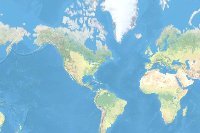

In [31]:
# Production table
item_prod = gis.content.get("c03078c5d91944beb3690ed5d50fa386")
item_prod

<Item title:"metadata_dev" type:Table Layer owner:greta.carrete_eowilson>
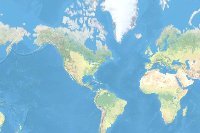

In [32]:
# Staging table
item_dev = gis.content.get("5336b506e049466892c55a003c2ffba9")
item_dev

In [33]:
cloning_list = [item_prod, item_dev]

In [34]:
cloning_list

[<Item title:"Metadata2" type:Feature Layer Collection owner:greta.carrete_eowilson>,
 <Item title:"metadata_dev" type:Table Layer owner:greta.carrete_eowilson>]

In [35]:
for i in cloning_list:
    print(i.url)

https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/Metadata2_181689b745764029a5e5773b5546935d/FeatureServer
https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/metadata_dev_9b97b2b52ee24999b16f461981dd3db1/FeatureServer


In [36]:
# Clone items (staging and production tables)
cloned_items = gis.content.clone_items(items=cloning_list)

In [37]:
cloned_items

[<Item title:"Metadata2" type:Feature Layer Collection owner:greta.carrete_eowilson>,
 <Item title:"metadata_dev" type:Table Layer owner:greta.carrete_eowilson>]

In [38]:
for i in cloned_items:
    print(i.url)

https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/Metadata2_c0fc60e53acf43d7afb3a2d4124b884b/FeatureServer
https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/metadata_dev_8f80db3d398e48f68d6199e7bf4968ad/FeatureServer


### Identify fields with different values
Source [notebook](https://developers.arcgis.com/python/sample-notebooks/updating-features-in-a-feature-layer/) by ESRI 

In [39]:
flayer_prod = cloned_items[0].layers[0]
prod_fset = flayer_prod.query() #querying without any conditions returns all the features
prod_sdf = prod_fset.sdf
prod_sdf.head()

,layerSlug,description,source,molLogo,Country,ObjectId,hasAdditionalContent,title,SHAPE
0,urban_human_pressures,Shows areas where the land is used by urban ac...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,Spain,1,FALSE,Urban pressures metadata,"{""x"": -405877.8881999999, ""y"": 4899122.8052000..."
1,irrigated_human_pressures,Shows areas where the land is used by irrigate...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,Spain,2,FALSE,Irrigated agriculture metadata,"{""x"": -405877.8881999999, ""y"": 4899122.8052000..."
2,rainfed_human_pressures,Shows areas where the land is used by rainfed ...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,Spain,3,FALSE,Rainfed agriculture metadata,"{""x"": -405877.8881999999, ""y"": 4899122.8052000..."
3,rangeland_human_pressures,Shows areas where the land is used by rangelan...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,Spain,4,FALSE,Rangeland metadata,"{""x"": -405877.8881999999, ""y"": 4899122.8052000..."
4,merged_land_human_pressures,Shows areas where there is high anthropogenic ...,"[Kennedy, Christina M., et al.](https://online...",FALSE,Spain,5,FALSE,Land human pressures metadata,"{""x"": -405877.8881999999, ""y"": 4899122.8052000..."


In [40]:
flayer_dev = cloned_items[1].tables[0]
dev_fset = flayer_dev.query() #querying without any conditions returns all the features
dev_sdf = dev_fset.sdf
dev_sdf.head()

,layerSlug,description,source,molLogo,hasAdditionalContent,title,ObjectId,GlobalID
0,urban_human_pressures,Shows areas where the land is used by urban ac...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Urban pressures metadata,1,8552660c-b9d0-455a-94c5-406ba0b29dd6
1,irrigated_human_pressures,Shows areas where the land is used by irrigate...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Irrigated agriculture metadata,2,a036a121-dd59-47f5-8bb2-b7adf2ec06cb
2,rainfed_human_pressures,Shows areas where the land is used by rainfed ...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Rainfed agriculture metadata,3,1e552ea5-81a0-416b-95b4-ae2bbaf4e1ba
3,rangeland_human_pressures,Shows areas where the land is used by rangelan...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Rangeland metadata,4,bfcbfd48-f76d-498b-9a94-56c568d5d64d
4,merged_land_human_pressures,Shows areas where there is high anthropogenic ...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Land human pressures metadata,5,00b2186c-593f-471b-bec6-41a87b273074


#### Identify rows that have new values

In [41]:
updatable_cols = ['layerSlug',
 'description',
 'source',
 'molLogo',
 'hasAdditionalContent',
 'title',
 'ObjectId']

In [42]:
prod_sdf[updatable_cols]

,layerSlug,description,source,molLogo,hasAdditionalContent,title,ObjectId
0,urban_human_pressures,Shows areas where the land is used by urban ac...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,FALSE,Urban pressures metadata,1
1,irrigated_human_pressures,Shows areas where the land is used by irrigate...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,FALSE,Irrigated agriculture metadata,2
2,rainfed_human_pressures,Shows areas where the land is used by rainfed ...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,FALSE,Rainfed agriculture metadata,3
3,rangeland_human_pressures,Shows areas where the land is used by rangelan...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,FALSE,Rangeland metadata,4
4,merged_land_human_pressures,Shows areas where there is high anthropogenic ...,"[Kennedy, Christina M., et al.](https://online...",FALSE,FALSE,Land human pressures metadata,5
...,...,...,...,...,...,...,...
60,marine-mammals-rarity,"Each cell in this view has an area of ~3,025 k...","Map Of Life, (Yale University).",TRUE,FALSE,Marine mammals rarity metadata,61
61,marine-mammals-priority,This layer illustrates where conservation effo...,"[Rinnan, D. Scott et al.](https://www.biorxiv....",TRUE,FALSE,Global marine mammals priority metadata,62
62,all-marine-vertebrates-richness,"Each cell in this view has an area of ~3,025 k...","Map Of Life, (Yale University).",TRUE,FALSE,Marine vertebrates richness metadata,63
63,all-marine-vertebrates-rarity,"Each cell in this view has an area of ~3,025 k...","Map Of Life, (Yale University).",TRUE,FALSE,Marine vertebrates rarity metadata,64


In [43]:
dev_sdf[updatable_cols]

,layerSlug,description,source,molLogo,hasAdditionalContent,title,ObjectId
0,urban_human_pressures,Shows areas where the land is used by urban ac...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Urban pressures metadata,1
1,irrigated_human_pressures,Shows areas where the land is used by irrigate...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Irrigated agriculture metadata,2
2,rainfed_human_pressures,Shows areas where the land is used by rainfed ...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Rainfed agriculture metadata,3
3,rangeland_human_pressures,Shows areas where the land is used by rangelan...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Rangeland metadata,4
4,merged_land_human_pressures,Shows areas where there is high anthropogenic ...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Land human pressures metadata,5
...,...,...,...,...,...,...,...
64,all-marine-vertebrates-priority,This layer illustrates where conservation effo...,"[Rinnan DS et al., 2021](https://www.biorxiv.o...",TRUE,FALSE,Global marine vertebrates priority metadata,65
65,land-human-pressures,Shows areas where there is high anthropogenic ...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Land human pressures metadata,66
66,places-future,None,"[Rinnan DS et al., 2021](https://www.biorxiv.o...",TRUE,FALSE,Places for Half-Earth future,67
67,butterflies-richness-1km,Each cell in this view measures 1 km x 1 km. W...,Map of Life and supporting datasets.,TRUE,FALSE,Butterflies richness metadata,68


In [44]:
overlap_rows = pd.merge(left = prod_sdf[updatable_cols], right = dev_sdf[updatable_cols], how='inner',
                       on = 'layerSlug')
overlap_rows

,layerSlug,description_x,source_x,molLogo_x,hasAdditionalContent_x,title_x,ObjectId_x,description_y,source_y,molLogo_y,hasAdditionalContent_y,title_y,ObjectId_y
0,urban_human_pressures,Shows areas where the land is used by urban ac...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,FALSE,Urban pressures metadata,1,Shows areas where the land is used by urban ac...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Urban pressures metadata,1
1,irrigated_human_pressures,Shows areas where the land is used by irrigate...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,FALSE,Irrigated agriculture metadata,2,Shows areas where the land is used by irrigate...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Irrigated agriculture metadata,2
2,rainfed_human_pressures,Shows areas where the land is used by rainfed ...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,FALSE,Rainfed agriculture metadata,3,Shows areas where the land is used by rainfed ...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Rainfed agriculture metadata,3
3,rangeland_human_pressures,Shows areas where the land is used by rangelan...,"(1) [Ellis, Erle C., et al.](http://ecotope.or...",FALSE,FALSE,Rangeland metadata,4,Shows areas where the land is used by rangelan...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Rangeland metadata,4
4,merged_land_human_pressures,Shows areas where there is high anthropogenic ...,"[Kennedy, Christina M., et al.](https://online...",FALSE,FALSE,Land human pressures metadata,5,Shows areas where there is high anthropogenic ...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Land human pressures metadata,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,marine-mammals-rarity,"Each cell in this view has an area of ~3,025 k...","Map Of Life, (Yale University).",TRUE,FALSE,Marine mammals rarity metadata,61,"Each cell in this view has an area of ~3,025 k...","Map Of Life, (Yale University).",TRUE,FALSE,Marine mammals rarity metadata,61
61,marine-mammals-priority,This layer illustrates where conservation effo...,"[Rinnan, D. Scott et al.](https://www.biorxiv....",TRUE,FALSE,Global marine mammals priority metadata,62,This layer illustrates where conservation effo...,"[Rinnan DS et al., 2021](https://www.biorxiv.o...",TRUE,FALSE,Global marine mammals priority metadata,62
62,all-marine-vertebrates-richness,"Each cell in this view has an area of ~3,025 k...","Map Of Life, (Yale University).",TRUE,FALSE,Marine vertebrates richness metadata,63,"Each cell in this view has an area of ~3,025 k...","Map Of Life, (Yale University).",TRUE,FALSE,Marine vertebrates richness metadata,63
63,all-marine-vertebrates-rarity,"Each cell in this view has an area of ~3,025 k...","Map Of Life, (Yale University).",TRUE,FALSE,Marine vertebrates rarity metadata,64,"Each cell in this view has an area of ~3,025 k...","Map Of Life, (Yale University).",TRUE,FALSE,Marine vertebrates rarity metadata,64


In [45]:
features_for_update = [] #list containing corrected features

all_features = prod_fset.features

In [46]:
for layerSlug in overlap_rows['layerSlug']:
    # get the feature to be updated
    original_feature = [f for f in all_features if f.attributes['layerSlug'] == layerSlug][0]
    feature_to_be_updated = deepcopy(original_feature)
    
    
    # get the matching row from dev
    matching_row = dev_sdf[updatable_cols].where(dev_sdf[updatable_cols].layerSlug == layerSlug).dropna()
    
    feature_to_be_updated.attributes['description'] = matching_row['description'].values[0]
    feature_to_be_updated.attributes['source'] = matching_row['source'].values[0]
    feature_to_be_updated.attributes['molLogo'] = matching_row['molLogo'].values[0]
    feature_to_be_updated.attributes['hasAdditionalContent'] = matching_row['hasAdditionalContent'].values[0]
    feature_to_be_updated.attributes['title'] = matching_row['title'].values[0]
    feature_to_be_updated.attributes['ObjectId'] = int(matching_row['ObjectId'])
    
    #add this to the list of features to be updated
    features_for_update.append(feature_to_be_updated)


In [47]:
flayer_prod.edit_features(updates= features_for_update)

{'addResults': [],
 'updateResults': [{'objectId': 1,
   'uniqueId': 1,
   'globalId': None,
   'success': True},
  {'objectId': 2, 'uniqueId': 2, 'globalId': None, 'success': True},
  {'objectId': 3, 'uniqueId': 3, 'globalId': None, 'success': True},
  {'objectId': 4, 'uniqueId': 4, 'globalId': None, 'success': True},
  {'objectId': 5, 'uniqueId': 5, 'globalId': None, 'success': True},
  {'objectId': 6, 'uniqueId': 6, 'globalId': None, 'success': True},
  {'objectId': 7, 'uniqueId': 7, 'globalId': None, 'success': True},
  {'objectId': 8, 'uniqueId': 8, 'globalId': None, 'success': True},
  {'objectId': 9, 'uniqueId': 9, 'globalId': None, 'success': True},
  {'objectId': 10, 'uniqueId': 10, 'globalId': None, 'success': True},
  {'objectId': 11, 'uniqueId': 11, 'globalId': None, 'success': True},
  {'objectId': 12, 'uniqueId': 12, 'globalId': None, 'success': True},
  {'objectId': 13, 'uniqueId': 13, 'globalId': None, 'success': True},
  {'objectId': 14, 'uniqueId': 14, 'globalId': Non

#### Identify new rows

In [48]:
new_rows = dev_sdf[~dev_sdf['layerSlug'].isin(overlap_rows['layerSlug'])]

In [49]:
new_rows

,layerSlug,description,source,molLogo,hasAdditionalContent,title,ObjectId,GlobalID
65,land-human-pressures,Shows areas where there is high anthropogenic ...,"(1) [Ellis, Erle C., et al., 2010](https://onl...",FALSE,FALSE,Land human pressures metadata,66,09970957-c5b2-4867-be2d-51ec1d0fc5e3
66,places-future,None,"[Rinnan DS et al., 2021](https://www.biorxiv.o...",TRUE,FALSE,Places for Half-Earth future,67,227fca8a-0383-4acb-9a84-5026eabb3723
67,butterflies-richness-1km,Each cell in this view measures 1 km x 1 km. W...,Map of Life and supporting datasets.,TRUE,FALSE,Butterflies richness metadata,68,c4494942-f702-4d11-8114-5275a3c72b9a
68,butterflies-rarity-1km,Each cell in this view measures 1 km x 1 km. W...,Map of Life and supporting datasets.,TRUE,FALSE,Butterflies rarity metadata,69,b7542682-f88e-4927-ad03-52f29153de61


In [50]:
features_to_be_added = []

# get a template feature object
template_feature = deepcopy(features_for_update[0])

# loop through each row and add to the list of features to be added
for row in new_rows.iterrows():
    new_feature = deepcopy(template_feature)
    
    #print
    print("Creating " + row[1]['layerSlug'])
    
    # assign the updated values 
    new_feature.attributes['layerSlug'] = row[1]['layerSlug']
    new_feature.attributes['description'] = row[1]['description']
    new_feature.attributes['source'] = row[1]['source']
    new_feature.attributes['molLogo'] = row[1]['molLogo']
    new_feature.attributes['hasAdditionalContent'] = row[1]['hasAdditionalContent']
    new_feature.attributes['title'] = row[1]['title']
    new_feature.attributes['ObjectId'] = int(row[1]['ObjectId'])
    
    
    #add this to the list of features to be updated
    features_to_be_added.append(new_feature)

Creating land-human-pressures
Creating places-future
Creating butterflies-richness-1km
Creating butterflies-rarity-1km


#### Update table

In [51]:
flayer_prod.edit_features(adds = features_to_be_added)

{'addResults': [{'objectId': 66,
   'uniqueId': 66,
   'globalId': None,
   'success': True},
  {'objectId': 67, 'uniqueId': 67, 'globalId': None, 'success': True},
  {'objectId': 68, 'uniqueId': 68, 'globalId': None, 'success': True},
  {'objectId': 69, 'uniqueId': 69, 'globalId': None, 'success': True}],
 'updateResults': [],
 'deleteResults': []}

In [52]:
features_to_be_added

[{"geometry": {"x": -405877.8881999999, "y": 4899122.805200003, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"layerSlug": "land-human-pressures", "description": "Shows areas where there is high anthropogenic pressure, which are represented as areas that have been highly modified or transformed from their natural state. The land use practices (1) that typically characterize these human pressures are urban areas, high-intensity agriculture, and low-intensity agriculture. Human pressures must be considered when establishing protected areas as some species are less tolerant of human disturbance.", "source": "(1) [Ellis, Erle C., et al., 2010](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1466-8238.2010.00540.x) (2) [Kennedy, Christina M., et al., 2019](https://onlinelibrary.wiley.com/doi/abs/10.1111/gcb.14549) (3) [ESA](https://www.esa-landcover-cci.org/)", "molLogo": "FALSE", "Country": "Spain", "ObjectId": 66, "hasAdditionalContent": "FALSE", "title": "La